<a href="https://colab.research.google.com/github/zevan07/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/Copy_of_LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
import random
dir(random)  # Reminding ourselves what we can do here
random.seed(10) # Sets Random Seed for reproducibility

In [3]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [4]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=172.07500125969045, mobile=False), User(purchased=False, time_on_site=242.1604565076447, mobile=True), User(purchased=True, time_on_site=172.4562884302345, mobile=True), User(purchased=False, time_on_site=134.30741730988564, mobile=True), User(purchased=False, time_on_site=176.6659151415657, mobile=False), User(purchased=False, time_on_site=98.57704667574383, mobile=True), User(purchased=False, time_on_site=141.90635886960914, mobile=True), User(purchased=False, time_on_site=46.30954508769639, mobile=True), User(purchased=True, time_on_site=568.9570603645093, mobile=False), User(purchased=False, time_on_site=64.57737234489078, mobile=True)]


In [5]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,172.075001,False
1,False,242.160457,True
2,True,172.456288,True
3,False,134.307417,True
4,False,176.665915,False


In [6]:
user_data.describe()

,time_on_site
count,1000.000000
mean,189.808593
std,127.484370
min,5.167894
25%,94.523032
50%,175.663445
75%,255.629865
max,599.904400


In [7]:
import numpy as np
user_data.describe(exclude=[np.number])

,purchased,mobile
count,1000,1000
unique,2,2
top,False,True
freq,644,750


In [8]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.167894147962072,5.230051694531813,5.859655940198439,6.0175026563650755,6.029351938631506,6.076534025386882,7.530625255773601,7.817115390608255,7.825127435732432,7.9926238138229575,8.340271367612646,8.606832008318156,9.218381144065109,10.058796842584638,10.05973343102422,10.098880952488393,10.269710128673584,10.624743380825596,10.775511794102913,10.837439718435094,10.847332077574741,11.300954145638592,11.66995174259849,11.675545744100827,11.782873882183889,11.841426573214946,12.392535053460403,12.40665438918597,12.92898208568828,12.955059196515535,12.996416835255978,13.382120427301592,13.54511635197098,13.934746202094221,14.137459282045185,15.38873657245532,16.922971203004536,17.353027809843624,17.447706834056127,17.662245360895042,...,482.6472145022762,485.9266783851125,486.4774281431866,489.8595383008188,492.78513492217877,495.15954119502254,497.0189957498146,499.3596843687688,502.23256501573536,503.5096132803155,510.3106040801197,513.7199567827874,514.524187056424,516.4726132592837,517.4950119989117,518.7549370475441,523.0318717844676,524.0890952881243,541.9178996100884,547.2149524114925,553.3795732755347,563.7377598676529,565.1913401235421,568.9570603645093,569.1394152918596,570.4001379889107,571.1747962145259,576.1168783345762,576.2458375079051,581.5998993123494,582.0038712877167,585.1679472229359,588.9784218509578,589.6238169166027,594.952201290341,595.4861528820476,595.6859588006147,597.9686255982785,599.821842253337,599.9043999383127
purchased,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,0,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,0,1,1,0,1,1,1,1,1,1,1,0,0,1,1,0,1,1,0,...,0,1,1,1,0,0,1,1,1,0,1,1,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,1,0,0,1,1,0,1,1,1,0,0,1,0
True,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,...,1,0,0,0,1,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,0,1,1,0,0,1,0,0,0,1,1,0,1


In [21]:
# !pip freeze # 0.24.2
!pip install pandas==0.23.4

     |████████████████████████████████| 8.9MB 4.7MB/s 
ERROR: google-colab 1.0.0 has requirement pandas~=0.24.0, but you'll have pandas 0.23.4 which is incompatible.
  Found existing installation: pandas 0.24.2
    Uninstalling pandas-0.24.2:
      Successfully uninstalled pandas-0.24.2


In [0]:
!pip freeze

In [16]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 6)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.573, 104.291]","(104.291, 203.413]","(203.413, 302.536]","(302.536, 401.659]","(401.659, 500.782]","(500.782, 599.904]"
purchased,,,,,,
False,207,180,169,41,30,17
True,77,109,133,10,12,15


In [17]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.573, 104.291]","(104.291, 203.413]","(203.413, 302.536]","(302.536, 401.659]","(401.659, 500.782]","(500.782, 599.904]"
purchased,,,,,,
False,0.728873,0.622837,0.559603,0.803922,0.714286,0.53125
True,0.271127,0.377163,0.440397,0.196078,0.285714,0.46875


In [18]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.728,0.616
True,0.272,0.384


In [19]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

pd.crosstab(user_data['mobile'], [user_data['purchased'], time_bins],
                rownames=['device'],
                colnames=['purchased', 'time on site'],
                normalize='index')

purchased               False        ...                      True 
time on site (4.573, 104.291]        ...         (500.782, 599.904]
device                               ...                           
False                   0.132        ...                       0.06
True                    0.232        ...                       0.00

[2 rows x 12 columns]

In [21]:
type(ct)

pandas.core.frame.DataFrame

In [23]:
ct.iloc[0:1, 1]

mobile
False    68
Name: True, dtype: int64

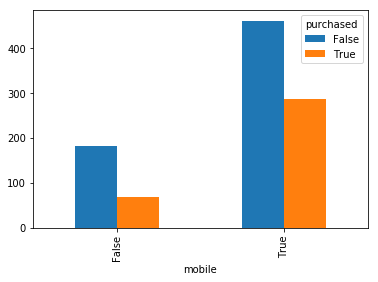

In [26]:
#missed pivot

ct.plot.bar()

In [29]:
ct = pd.crosstab(time_bins, [user_data['purchased'], user_data['mobile']],
                normalize='columns')
ct

purchased              False               True           
mobile                 False     True      False     True 
time_on_site                                              
(4.573, 104.291]    0.181319  0.376623  0.073529  0.250000
(104.291, 203.413]  0.142857  0.333333  0.161765  0.340278
(203.413, 302.536]  0.192308  0.290043  0.220588  0.409722
(302.536, 401.659]  0.225275  0.000000  0.147059  0.000000
(401.659, 500.782]  0.164835  0.000000  0.176471  0.000000
(500.782, 599.904]  0.093407  0.000000  0.220588  0.000000

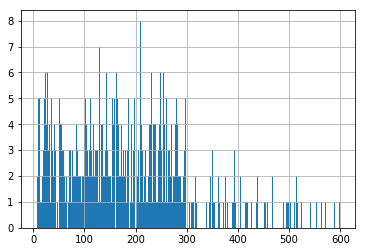

In [30]:
user_data['time_on_site'].hist(bins=600)

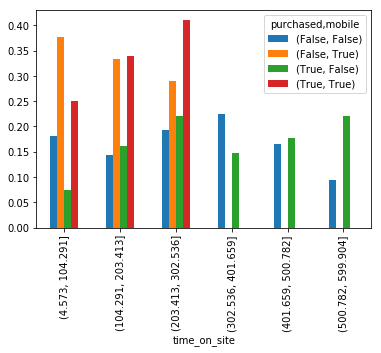

In [31]:
ct.plot(kind='bar')

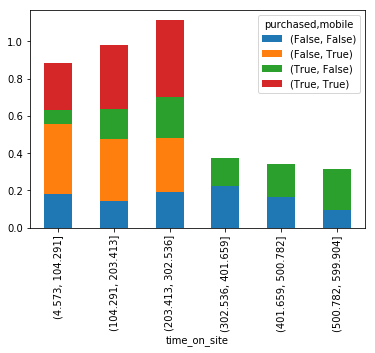

In [32]:
ct.plot(kind='bar', stacked = True)

In [0]:
#find the columns of purchased mobile, desktop

ct_final = ct.iloc[:, [2,3]]

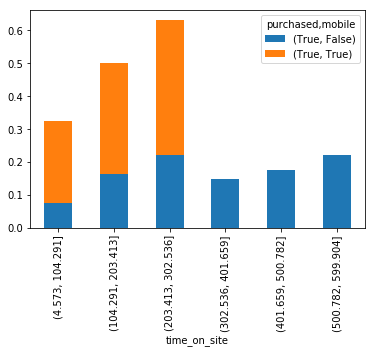

In [41]:
ct_final.plot(kind='bar', stacked=True)

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [79]:
# TODO - your code here
# Use what we did live in lecture as an example

#import csv through url
persons_url = 'https://raw.githubusercontent.com/zevan07/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module3-databackedassertions/persons.csv'

df = pd.read_csv(persons_url)

#show first five rows
df.head()

,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


In [47]:
#show shape
df.shape

(1200, 4)

In [48]:
#ensure there are no missing values
df.isnull().sum()

Unnamed: 0       0
age              0
weight           0
exercise_time    0
dtype: int64

In [49]:
#look at various analytical tools applied to data
df.describe()

,Unnamed: 0,age,weight,exercise_time
count,1200.000000,1200.000000,1200.000000,1200.000000
mean,599.500000,48.396667,153.540833,134.910833
std,346.554469,18.166802,35.132182,85.548895
min,0.000000,18.000000,100.000000,0.000000
25%,299.750000,33.000000,125.000000,65.000000
50%,599.500000,48.000000,149.000000,122.000000
75%,899.250000,64.000000,180.250000,206.000000
max,1199.000000,80.000000,246.000000,300.000000


In [81]:
#bin the data before we do a crosstabulation in order to help make better sense of it
age_bins = pd.cut(df['age'], 5)
time_bins = pd.cut(df['exercise_time'], 5)
weight_bins = pd.cut(df['weight'], 5)
unnamed_bins = pd.cut(df['Unnamed: 0'], 5)
ct = pd.crosstab([time_bins], [age_bins, weight_bins])

ct

age             (17.938, 30.4]      ...         (67.6, 80.0]
weight         (99.854, 129.2]      ...       (216.8, 246.0]
exercise_time                       ...                     
(-0.3, 60.0]                10      ...                   15
(60.0, 120.0]                9      ...                    7
(120.0, 180.0]              17      ...                    0
(180.0, 240.0]              19      ...                    0
(240.0, 300.0]              25      ...                    0

[5 rows x 25 columns]

In [77]:
#from the above crosstable we can see that exercise time decreases
#both with increase in weight and increase in age
#so we'll take this knowledge into account while we make charts

#construct pivot tables for each binning that we've constructed
pt_weight = pd.pivot_table(df, values='exercise_time', index=weight_bins)
pt

,exercise_time
weight,
"(99.854, 129.2]",171.168000
"(129.2, 158.4]",161.038806
"(158.4, 187.6]",112.240310
"(187.6, 216.8]",73.111732
"(216.8, 246.0]",32.301887


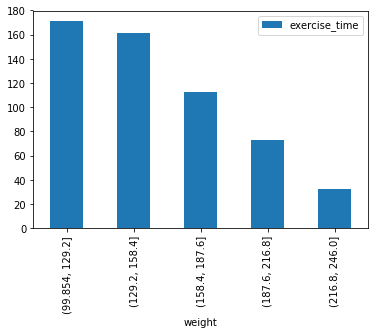

In [74]:
#increase in weight only decreases exercise time
pt_weight.plot.bar()

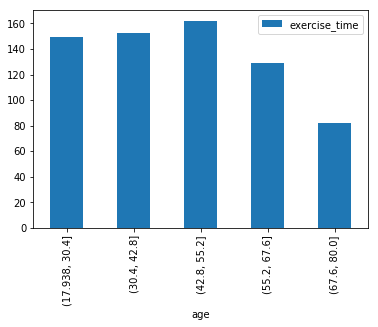

In [75]:
#We can see that exercise first increases and then decreases with age
pt_age = pd.pivot_table(df, values='exercise_time', index=age_bins)

pt_age.plot.bar()

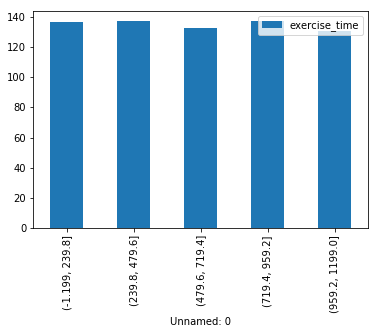

In [110]:
#for kicks let's check out if there's any correlation between
#the ordinal unnamed column and exercise time
pt_unnamed = pd.pivot_table(df, values='exercise_time', index=unnamed_bins)

#to make it look like there's a real relationship here,
#let's change the domain and range of the graph
pt_unnamed.plot.bar()


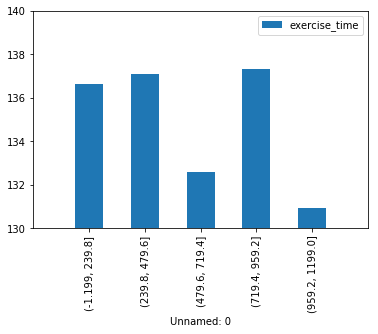

In [111]:
#to make it look like there's a real relationship here,
#let's change the domain and range of the graph
pt_unnamed.plot.bar()
plt.axis([-1, 5, 130, 140]);

In [86]:
#Since the way we've binned the data is relatively fine-grained
#we'll coarse grain some of it so that it's easier to use for bar charts
age_bins = pd.cut(df['age'], 2)
# time_bins = pd.cut(df['exercise_time'], 5)
weight_bins = pd.cut(df['weight'], 2)

ct = pd.crosstab(time_bins, [age_bins, weight_bins],
                normalize='columns')
ct

age             (17.938, 49.0]      ...         (49.0, 80.0]
weight         (99.854, 173.0]      ...       (173.0, 246.0]
exercise_time                       ...                     
(-0.3, 60.0]          0.117647      ...             0.402010
(60.0, 120.0]         0.161765      ...             0.402010
(120.0, 180.0]        0.186975      ...             0.160804
(180.0, 240.0]        0.250000      ...             0.035176
(240.0, 300.0]        0.283613      ...             0.000000

[5 rows x 4 columns]

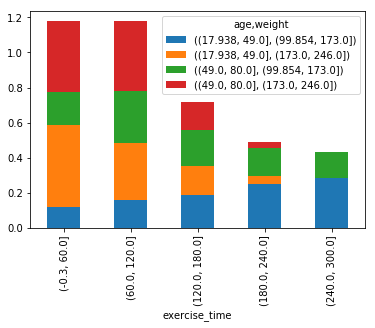

In [87]:
#this plot clearly shows that among those who exercise for the longest,
#there are little to no people within the higher weight bin
ct.plot(kind='bar', stacked=True)

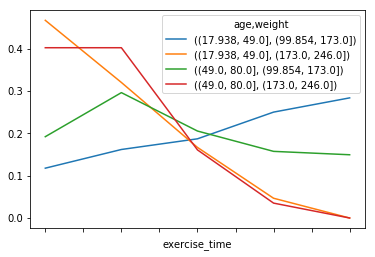

In [90]:
ct.plot();

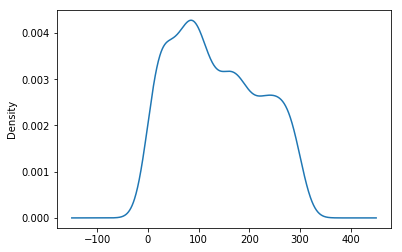

In [89]:
df['exercise_time'].plot.density();

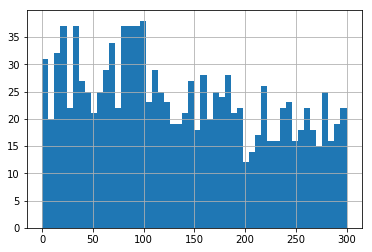

In [98]:
df['exercise_time'].hist(bins=50);

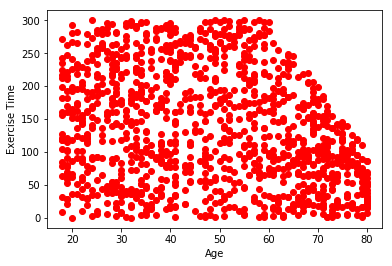

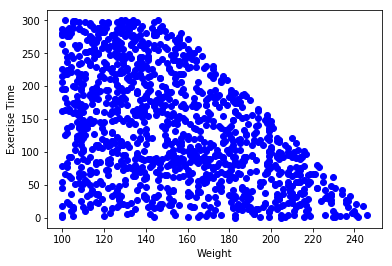

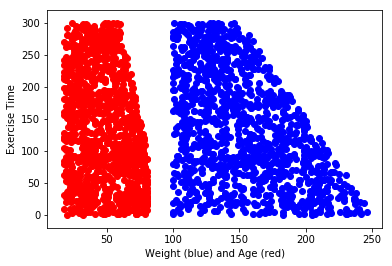

In [122]:
#we know that both age and weight correlate with exercise time, 
#but to what degree do each of them affect exercise time?
#by plotting both on the same scatterplot, we can see that age and weight
#both have effects, but that weight has a much more significant effect

fig,ax1 = plt.subplots()
ax1.set_xlabel('Age')
ax1.set_ylabel('Exercise Time')
plt.scatter(df['age'], df['exercise_time'], color='red')

fig,ax2 = plt.subplots()
ax2.set_xlabel('Weight')
ax2.set_ylabel('Exercise Time')
plt.scatter(df['weight'], df['exercise_time'], color='blue')

#it should be remembered that age and weight are being graphed on the same axis
fig,ax3 = plt.subplots()
ax3.set_xlabel('Weight (blue) and Age (red)')
ax3.set_ylabel('Exercise Time')
plt.scatter(df['weight'], df['exercise_time'], color='blue')
plt.scatter(df['age'], df['exercise_time'], color='red');

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?

Age, weight, and exercise time may all be considered discrete since they take whole number values in a range, but we can also treat them as continuous. 

2.  What are the relationships between the variables?

As age increases, exercise time increases and then decreases. As weight increases, exercise time decreases. 

3.  Which relationships are "real", and which spurious?

The very contrived example of using the 'Unnamed' attribute, which is really just an ordinal list of numbers, and changing the y-values of the chart is obviously a spurious relationship. One might mistake it for real if one did not pay close enough attention to the scale/range of values on the side of the chart. 

It appears that the other relationships, exercise time to age and weight are real, though. However, it's clear that age is much less significant a factor than weight. 

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)

In [185]:
mov_file = 'tmdb_5000_movies.csv'
mov_data = pd.read_csv(mov_file)
mov_data.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [0]:
mov_data.fillna({'release_date':'2000-01-01'}, inplace=True)

In [187]:
mov_data['year'] = mov_data.release_date.astype(str).str[:4].astype(int)
mov_data.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,year
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,2009
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,2007
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,2015
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,2012
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,2012


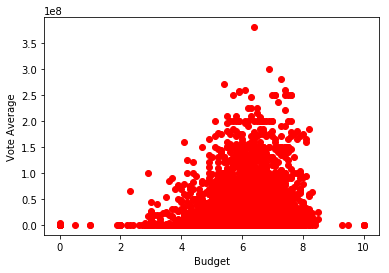

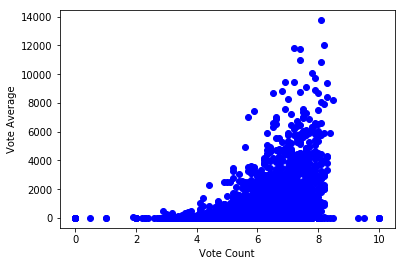

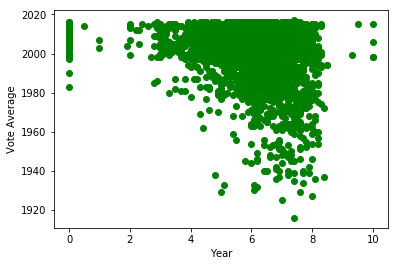

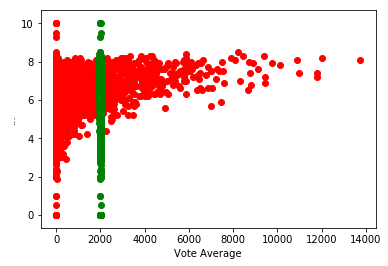

In [197]:
fig,ax1 = plt.subplots()
ax1.set_xlabel('Budget')
ax1.set_ylabel('Vote Average')
plt.scatter(mov_data['vote_average'], mov_data['budget'], color='red')

fig,ax2 = plt.subplots()
ax2.set_xlabel('Vote Count')
ax2.set_ylabel('Vote Average')
plt.scatter(mov_data['vote_average'], mov_data['vote_count'], color='blue')

fig,ax3 = plt.subplots()
ax3.set_xlabel('Year')
ax3.set_ylabel('Vote Average')
plt.scatter(mov_data['vote_average'], mov_data['year'], color='green')

fig,ax4 = plt.subplots()
ax4.set_xlabel('Vote Average')
ax4.set_ylabel('...')
plt.scatter(mov_data['vote_count'], mov_data['vote_average'], color='red')
plt.scatter(mov_data['year'], mov_data['vote_average'], color='green')